### KNN Alogorithm: Weekly Time Series Returns and Five Day Standard Deviation.

#### Steps:
* Calculate 5 day returns and their correponding standard deviation for 5 samples.
* Treat each series as a seperate collection.
    * Collection Id = Fund Name + Series Id
* Slice the data to start from 2019-01-01, dropping NAN we have 2312 funds.
* Groupby and visualize funds respect to aafmclassification and svsclassification.
* KNN Classifier for aafm category funds.

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets, neighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from mlxtend.plotting import plot_decision_regions
from collections import Counter

In [15]:
# read
data = pd.read_csv(r'../data/raw/daily/Fondos_Mutuos_2018_column.csv') \
       .append(pd.read_csv(r'../data/raw/daily/Fondos_Mutuos_2019_column.csv'), ignore_index=True) \
       .append(pd.read_csv(r'../data/raw/daily/Fondos_Mutuos_2020_column.csv'), ignore_index=True) \
       .append(pd.read_csv(r'../data/raw/daily/Fondos_Mutuos_2021_column_ytd.csv'), ignore_index=True) \
       .drop(['Unnamed: 0'], axis=1)

# format date
data['fecha'] = pd.to_datetime(data['fecha'],format='%Y%m%d')

# project
data = data[['administratorName','fundRUN','fundName','fundSeries','installmentValue','aafmCategory','svsCategory','efectivePatrimony','installmentsInCirculation','currency','fecha']]

# merge fundrun with series
data['runserie'] = data['fundRUN'] + data['fundSeries']

#time series
data_ts = data[['runserie','installmentValue','fecha']] \
          .groupby(['fecha','runserie']) \
          .mean() \
          .reset_index() \
          .pivot(index='fecha', columns='runserie', values='installmentValue')

# drop last row NAN
data_ts = data_ts.loc[:,~data_ts.iloc[-1].isna()]

# returns 5 days
data_ts_return = data_ts.pct_change(5)

# std 5 sample of 5 day returns
data_ts_std = data_ts_return.rolling(5).std()

# drop columns with less than 2019-01-01 / 2835 columns
data_ts_r2 = data_ts_return.loc['2019-01-01':'2021-02-08']
data_ts_std2 = data_ts_std.loc['2019-01-01':'2021-02-08']

# drop rows with NANs 2312 columns
data_ts_r2 = data_ts_r2.dropna(axis='columns').loc[:, (data_ts_r2 != 0).any(axis=0)]
data_ts_std2 = data_ts_std2.dropna(axis='columns')

# info table
data_info = data[data['fecha']=='2021-02-08'].set_index('runserie')[['administratorName','fundName','aafmCategory','svsCategory','currency']]

# data_ratio would be our output to calculate ML algorithms.
data_ratio = pd.DataFrame(data_ts_r2.mean(),columns=['mean_return'])
data_ratio['mean_std'] = data_ts_std2.mean()
data_ratio['riskadj_ratio'] = data_ratio['mean_return'] / data_ratio['mean_std']

# dropnan
data_ratio = data_ratio.dropna(axis='rows')

# final data set is the information with the return and std.
data_final = data_ratio.join(data_info)

In [16]:
data_final

,mean_return,mean_std,riskadj_ratio,administratorName,fundName,aafmCategory,svsCategory,currency
runserie,,,,,,,,
8011-K100,0.000241,0.000108,2.223767,PRINCIPAL,VISION MONEY MARKET,Fondos de Deuda < 90 Dias Nacional,FM DE INV.EN INST.DE DEUDA DE C/P CON DURACION...,P
8011-KB,0.000177,0.000109,1.626347,PRINCIPAL,VISION MONEY MARKET,Fondos de Deuda < 90 Dias Nacional,FM DE INV.EN INST.DE DEUDA DE C/P CON DURACION...,P
8011-KC,0.000208,0.000108,1.921714,PRINCIPAL,VISION MONEY MARKET,Fondos de Deuda < 90 Dias Nacional,FM DE INV.EN INST.DE DEUDA DE C/P CON DURACION...,P
8011-KCASH,0.000173,0.000109,1.590427,PRINCIPAL,VISION MONEY MARKET,Fondos de Deuda < 90 Dias Nacional,FM DE INV.EN INST.DE DEUDA DE C/P CON DURACION...,P
8011-KG,0.000138,0.000109,1.269680,PRINCIPAL,VISION MONEY MARKET,Fondos de Deuda < 90 Dias Nacional,FM DE INV.EN INST.DE DEUDA DE C/P CON DURACION...,P
...,...,...,...,...,...,...,...,...
9693-8A,0.000223,0.001277,0.174724,BANCO INTERNACIONAL,BI DINAMICO,Fondos de Deuda > 365 Dias Orig. Flex,FM DE INV.EN INST.DE DEUDA DE MEDIANO Y LARGO ...,P
9693-8B,0.000248,0.001277,0.194590,BANCO INTERNACIONAL,BI DINAMICO,Fondos de Deuda > 365 Dias Orig. Flex,FM DE INV.EN INST.DE DEUDA DE MEDIANO Y LARGO ...,P
9693-8C,0.000274,0.001277,0.214610,BANCO INTERNACIONAL,BI DINAMICO,Fondos de Deuda > 365 Dias Orig. Flex,FM DE INV.EN INST.DE DEUDA DE MEDIANO Y LARGO ...,P


In [17]:
# export excel data
# data_final.to_excel(r'weekly_data.xlsx')

#### Number of Funds by aafmclassification

In [18]:
data_final.groupby(['aafmCategory','currency']) \
          .count() \
          .sort_values(by=['currency','riskadj_ratio'], ascending=False) \
          ['riskadj_ratio']

aafmCategory                                                                                    currency
Balanceado Agresivo                                                                             P           182
Balanceado Moderado                                                                             P           178
Fondos de Deuda < 90 Dias Nacional                                                              P           166
Accionario Nacional Large CAP                                                                   P           157
Balanceado Conservador                                                                          P           157
Fondos de Deuda > 365 Dias Orig. Flex                                                           P           110
Fondos de Deuda > 365 Dias Nacional, Inversion UF > 3 años y =<5                                P            99
Fondos de Deuda < 365 Dias Nacional en pesos                                                    P            95

#### AAFM Category: Average Return/Std

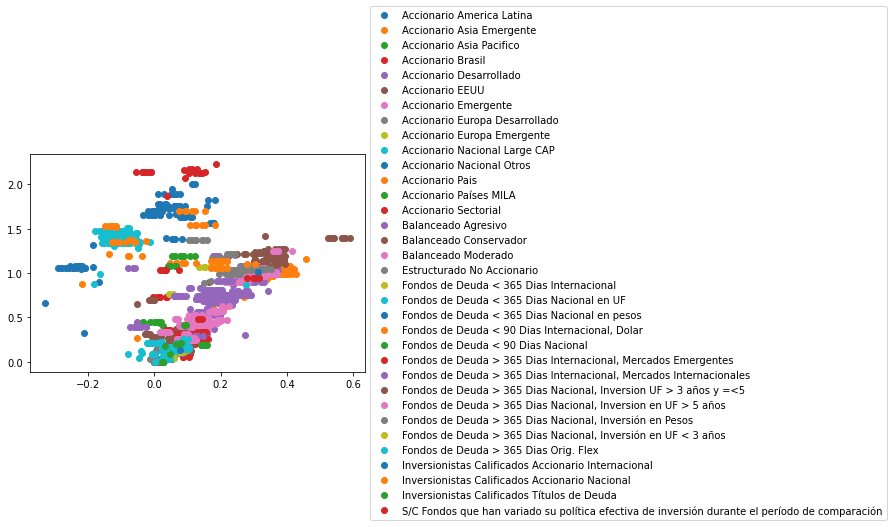

In [19]:
# visualize the different type of funds aafm
groups=data_final.groupby('aafmCategory')
for name, group in groups:
    plt.plot(group['mean_return'] * 100, group['mean_std']*100, marker="o", linestyle="", label=name)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

#### Number of Funds by svsclassification

In [20]:
data_final.groupby(['svsCategory','currency']) \
          .count() \
          .sort_values(by=['currency','riskadj_ratio'], ascending=False) \
          ['riskadj_ratio']

svsCategory                                                 currency
FM DE LIBRE INVERSION                                       P           703
FM DE INVERSION EN INSTRUMENTOS DE CAPITALIZACION           P           461
FM DE INV.EN INST.DE DEUDA DE MEDIANO Y LARGO PLAZO         P           359
FM DE INV.EN INST.DE DEUDA DE C/P CON DURACION <= 90 DIAS   P           166
FM DE INV.EN INST.DE DEUDA DE C/P CON DURACION <= 365 DIAS  P           130
FM MIXTO                                                    P           124
FM DIRIGIDO A INVERSIONISTAS CALIFICADOS                    P            29
FM ESTRUCTURADO                                             P             5
FM DE LIBRE INVERSION                                       D            83
FM DE INV.EN INST.DE DEUDA DE C/P CON DURACION <= 90 DIAS   D            40
FM DE INV.EN INST.DE DEUDA DE MEDIANO Y LARGO PLAZO         D            37
FM MIXTO                                                    D            34
FM DE INVERSION EN 

#### SVS Category: Average Return/Std

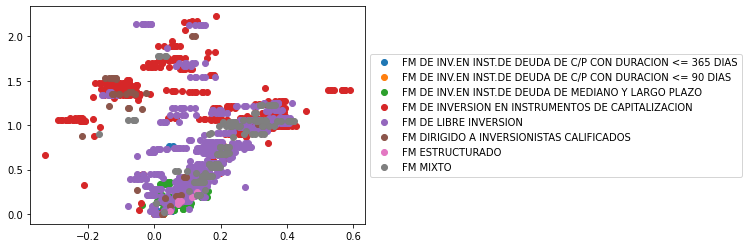

In [21]:
# visualize the different type of funds aafm
groups=data_final.groupby('svsCategory')
for name, group in groups:
    plt.plot(group['mean_return']*100, group['mean_std']*100, marker="o", linestyle="", label=name)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

#### KNN Classification Algorithm

In [22]:
# Calculate monthly returnschange 
data_return=pd.DataFrame(data_ts_r2.rolling(4).mean().loc['2021-02-03':'2021-02-08'].T.values,index=data_ts_r2.rolling(4).mean().loc['2021-02-03':'2021-02-08'].T.index,columns=['r1','r2','r3','r4','r5','r6'])
data_std=pd.DataFrame(data_ts_std2.rolling(4).mean().loc['2021-02-03':'2021-02-08'].T.values,index=data_ts_std2.rolling(4).mean().loc['2021-02-03':'2021-02-08'].T.index,columns=['s1','s2','s3','s4','s5','s6'])
data_knn=round(data_return.join(data_std).join(data_info['aafmCategory']),8).dropna(axis='rows')
data_knn.head()

,r1,r2,r3,r4,r5,r6,s1,s2,s3,s4,s5,s6,aafmCategory
runserie,,,,,,,,,,,,,
8011-K100,-0.000083,-0.000025,0.000105,0.000222,0.000304,0.000455,0.000143,0.000142,0.000155,0.00017,0.000172,0.000196,Fondos de Deuda < 90 Dias Nacional
8011-KB,-0.000153,-0.000094,0.000036,0.000153,0.000235,0.000386,0.000143,0.000142,0.000155,0.00017,0.000172,0.000196,Fondos de Deuda < 90 Dias Nacional
8011-KC,-0.000118,-0.000060,0.000070,0.000188,0.000269,0.000420,0.000143,0.000142,0.000155,0.00017,0.000172,0.000196,Fondos de Deuda < 90 Dias Nacional
8011-KCASH,-0.000157,-0.000098,0.000032,0.000149,0.000231,0.000381,0.000143,0.000142,0.000155,0.00017,0.000172,0.000196,Fondos de Deuda < 90 Dias Nacional
8011-KG,-0.000194,-0.000136,-0.000006,0.000112,0.000193,0.000344,0.000143,0.000142,0.000155,0.00017,0.000172,0.000196,Fondos de Deuda < 90 Dias Nacional


In [23]:
# Features data_knn columns-1, last column is the target label
from sklearn import preprocessing

# Converting string labels into numbers.
# creating labelEncoder
le = preprocessing.LabelEncoder()
label = le.fit_transform(data_knn['aafmCategory'])

# features list
features=[]
for i in range(0,len(data_knn.loc[:, data_knn.columns != 'aafmCategory'])):
    (a,b,c,d,e,f,g,d,e,w,t,y)=data_knn.loc[:, data_knn.columns != 'aafmCategory'].iloc[i].astype(float)
    features.append((a,b,c,d,e,f,g,d,e,w,t,y))

In [24]:
features[0:5]

[(-8.35e-05,
  -2.476e-05,
  0.00010488,
  0.00014202,
  0.00015537,
  0.0004548,
  0.00014343,
  0.00014202,
  0.00015537,
  0.00016994,
  0.00017223,
  0.0001963),
 (-0.00015274,
  -9.403e-05,
  3.561e-05,
  0.00014202,
  0.00015537,
  0.00038552,
  0.00014344,
  0.00014202,
  0.00015537,
  0.00016993,
  0.00017223,
  0.0001963),
 (-0.00011844,
  -5.971e-05,
  6.993e-05,
  0.00014201,
  0.00015537,
  0.00041988,
  0.00014342,
  0.00014201,
  0.00015537,
  0.00016994,
  0.00017225,
  0.00019632),
 (-0.00015685,
  -9.812e-05,
  3.151e-05,
  0.00014201,
  0.00015536,
  0.00038141,
  0.00014342,
  0.00014201,
  0.00015536,
  0.00016993,
  0.00017222,
  0.00019629),
 (-0.00019434,
  -0.00013561,
  -5.98e-06,
  0.000142,
  0.00015536,
  0.0003439,
  0.00014341,
  0.000142,
  0.00015536,
  0.00016992,
  0.00017221,
  0.00019628)]

In [25]:
# LABEL DETAILS.
label_unique=pd.DataFrame(label)[0].unique()
ids=pd.DataFrame(label_unique,columns=['IDLABEL'])
ids['aafm_name']=data_knn['aafmCategory'].unique()
ids.sort_values('IDLABEL')

,IDLABEL,aafm_name
12,0,Accionario America Latina
15,1,Accionario Asia Emergente
14,2,Accionario Asia Pacifico
25,3,Accionario Brasil
10,4,Accionario Desarrollado
9,5,Accionario EEUU
6,6,Accionario Emergente
11,7,Accionario Europa Desarrollado
29,8,Accionario Europa Emergente
4,9,Accionario Nacional Large CAP


In [26]:
# type the variables and it will classify your model
model = KNeighborsClassifier(n_neighbors=5)

# Train the model using the training sets
model.fit(features,label)

# Predict Output, input variables
predicted = model.predict([[10,10,10,10,10,10,0,0,0,0,0,0]])

print(predicted)

[11]


In [27]:
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(data_knn.loc[:, data_knn.columns != 'aafmCategory'].astype(float), label, test_size=0.3) # 70% training and 30% test

#Create KNN Classifier
knn = KNeighborsClassifier(n_neighbors=5)

#Train the model using the training sets
knn.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = knn.predict(X_test)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.8502269288956127


In [28]:
sum(y_test==y_pred)/len(y_pred)

0.8502269288956127

/home/vscode/.local/lib/python3.8/site-packages/mlxtend/plotting/decision_regions.py:275: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x=x_data,


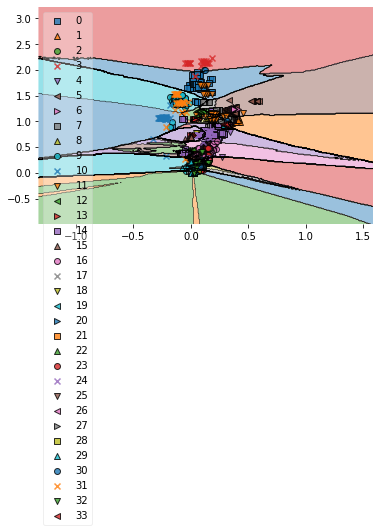

In [29]:
x_and_y            = (data_final[["mean_return", "mean_std"]] * 100).values
unique_label_count = len(Counter(label).keys())

classifier = neighbors.KNeighborsClassifier(n_neighbors=unique_label_count)
classifier.fit(x_and_y, label)

plot_decision_regions(x_and_y, label, clf=classifier, legend=2)

plt.show()

## Augmented Dataframe With Predicted Labels

In [86]:
def getAAFMNameById(id):
    return ids.loc[ids['IDLABEL'] == id]['aafm_name'].iloc[0]

predicted_label_ids = knn.predict(features)
predicted_labels = list(map(getAAFMNameById, predicted_label_ids))

augmented_data = data_final.copy()
augmented_data["predicted_aafmCategory"] = predicted_labels

augmented_data.head()

,mean_return,mean_std,riskadj_ratio,administratorName,fundName,aafmCategory,svsCategory,currency,predicted_aafmCategory
runserie,,,,,,,,,
8011-K100,0.000241,0.000108,2.223767,PRINCIPAL,VISION MONEY MARKET,Fondos de Deuda < 90 Dias Nacional,FM DE INV.EN INST.DE DEUDA DE C/P CON DURACION...,P,Fondos de Deuda < 90 Dias Nacional
8011-KB,0.000177,0.000109,1.626347,PRINCIPAL,VISION MONEY MARKET,Fondos de Deuda < 90 Dias Nacional,FM DE INV.EN INST.DE DEUDA DE C/P CON DURACION...,P,Fondos de Deuda < 90 Dias Nacional
8011-KC,0.000208,0.000108,1.921714,PRINCIPAL,VISION MONEY MARKET,Fondos de Deuda < 90 Dias Nacional,FM DE INV.EN INST.DE DEUDA DE C/P CON DURACION...,P,Fondos de Deuda < 90 Dias Nacional
8011-KCASH,0.000173,0.000109,1.590427,PRINCIPAL,VISION MONEY MARKET,Fondos de Deuda < 90 Dias Nacional,FM DE INV.EN INST.DE DEUDA DE C/P CON DURACION...,P,Fondos de Deuda < 90 Dias Nacional
8011-KG,0.000138,0.000109,1.269680,PRINCIPAL,VISION MONEY MARKET,Fondos de Deuda < 90 Dias Nacional,FM DE INV.EN INST.DE DEUDA DE C/P CON DURACION...,P,Fondos de Deuda < 90 Dias Nacional
